# Práctica 4: Procesamieto de audio

### **Participantes:**
- Gerardo León Quintana
- Susana Suárez Mendoza

## Ejercicio 1:

Construir un identificador de notas musicales. Es decir; en su versión más sencilla (y suficiente) la entrada es un sonido con una sola nota musical y debe identificar cuál es. Por simplicidad elija un único instrumento para la identificación.

## Ejercicio 2:

Construir una pequeña aplicación que permita operar con diferentes filtros (con un selector) y trabajar con varios umbrales. (uno para los filtros pasa-bajo y pasa-alto y dos para los filtros pasa-banda y rechaza-banda). Demuestre su funcionalidad con señales ruidosas. Muestre en cada filtrado la señal original y filtrada en el dominio temporal y en el dominio de la frecuencia.

# gerardo branch

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz
from scipy.io import wavfile

In [22]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandstop(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='bandstop')
    return b, a


In [23]:
# Función para aplicar un filtro
def apply_filter(data, b, a):
    y = lfilter(b, a, data)
    return y

# Función para plotear en el dominio temporal y de frecuencia
def plot_signal(time, signal, fs, title):
    plt.figure(figsize=(12, 6))
    
    # Dominio temporal
    plt.subplot(2, 1, 1)
    plt.plot(time, signal)
    plt.title(f'{title} - Time Domain')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    
    # Dominio de frecuencia
    plt.subplot(2, 1, 2)
    freqs = np.fft.fftfreq(len(signal), 1/fs)
    fft_spectrum = np.fft.fft(signal)
    plt.plot(freqs[:len(freqs)//2], np.abs(fft_spectrum)[:len(freqs)//2])
    plt.title(f'{title} - Frequency Domain')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Amplitude')
    
    plt.tight_layout()
    plt.show()


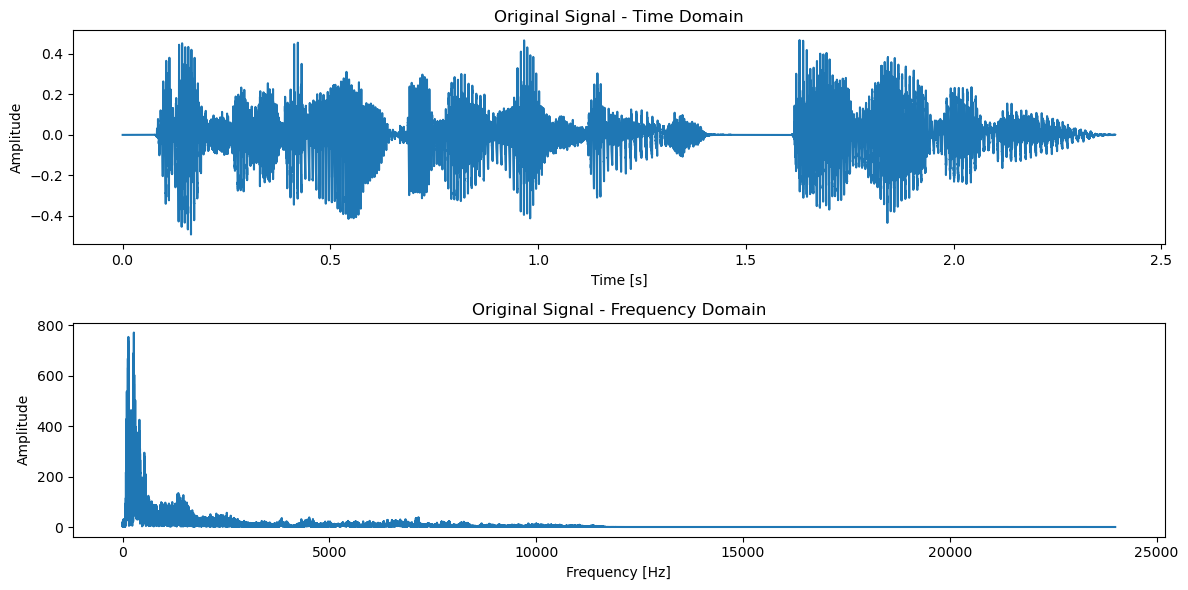

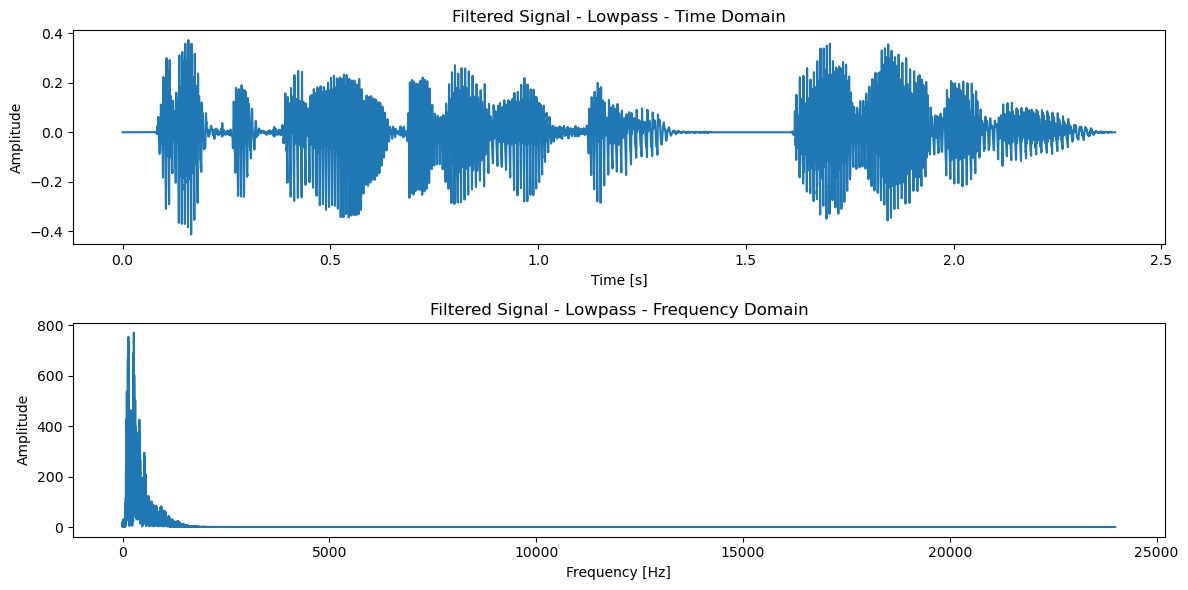

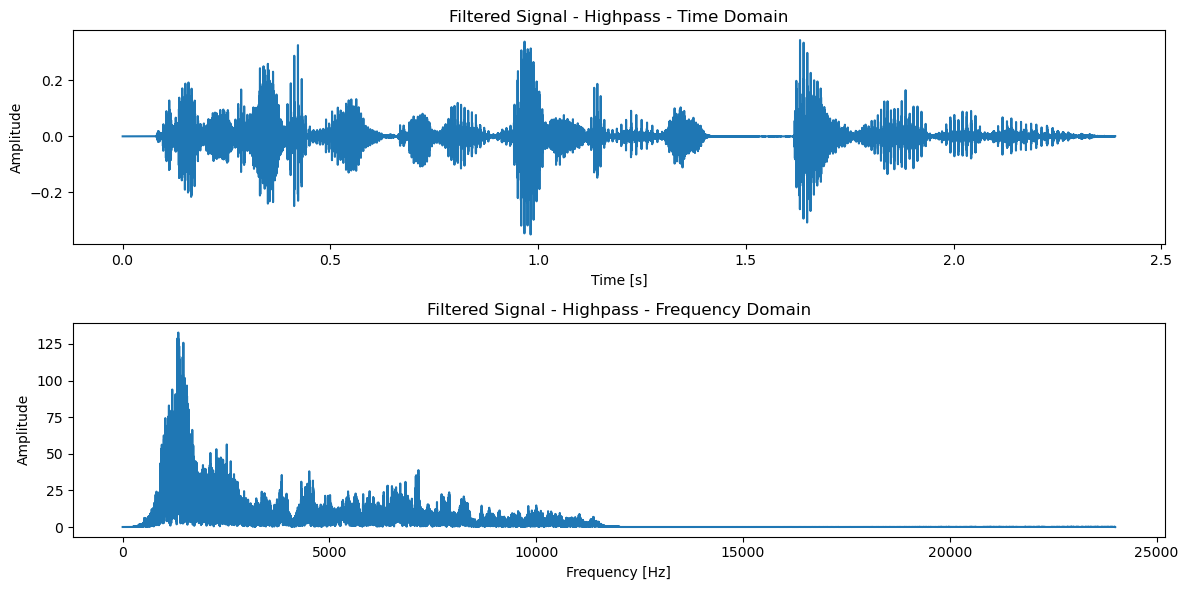

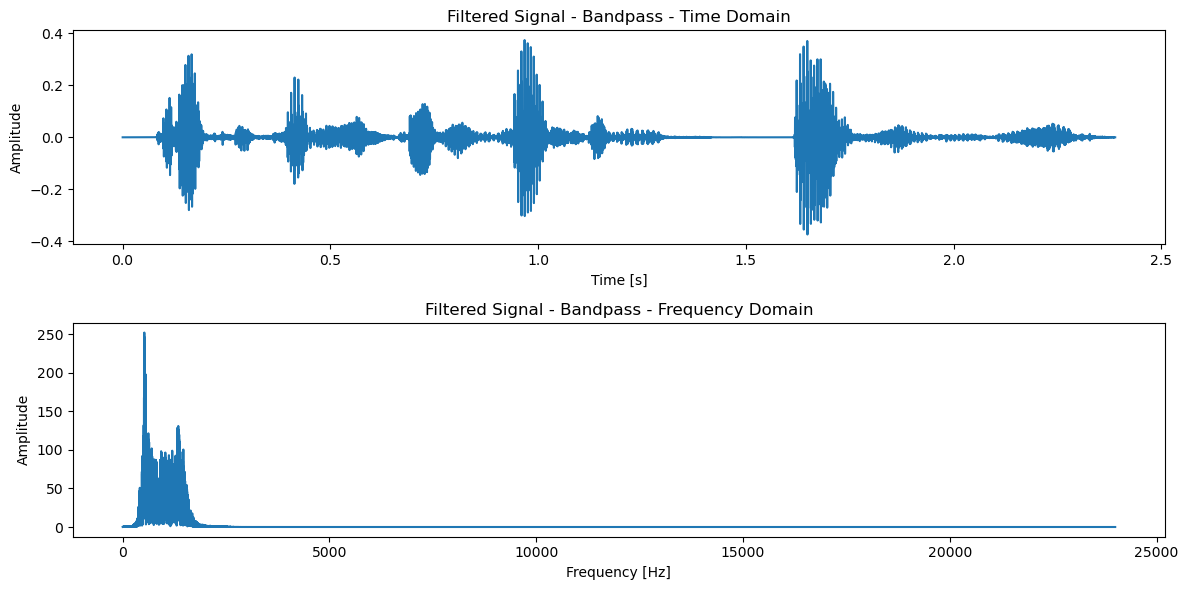

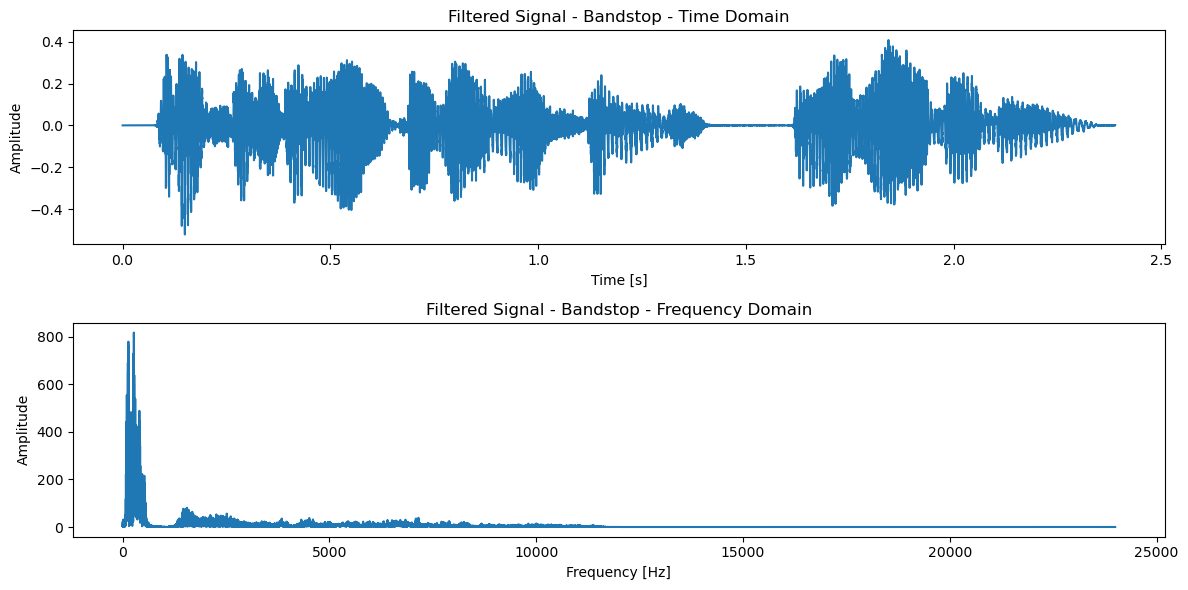

In [25]:

# Leer archivo de audio
input_wav_file = 'un_archivo_audio.wav'
fs, data = wavfile.read(input_wav_file)

# Normalizar si es necesario
if data.dtype == np.int16:
    data = data / 32768.0
elif data.dtype == np.int32:
    data = data / 2147483648.0

# Si el archivo de audio es estéreo, seleccionar un canal
if len(data.shape) == 2:
    data = data[:, 0]

# Crear vector de tiempo
t = np.arange(0, len(data) / fs, 1 / fs)

# Parámetros del filtro
order = 6

# Filtros y sus parámetros
filters = {
    'lowpass': {'func': butter_lowpass, 'params': {'cutoff': 1000}},
    'highpass': {'func': butter_highpass, 'params': {'cutoff': 1000}},
    'bandpass': {'func': butter_bandpass, 'params': {'lowcut': 500, 'highcut': 1500}},
    'bandstop': {'func': butter_bandstop, 'params': {'lowcut': 500, 'highcut': 1500}}
}

plot_signal(t, data, fs, 'Original Signal')

for filter in filters:
    b, a = filters[filter]['func'](fs=fs, order=order, **filters[filter]['params'])
    filtered_data = apply_filter(data, b, a)
    plot_signal(t, filtered_data, fs, f'Filtered Signal - {filter.capitalize()}')

    # filtered_data_int = np.int16(filtered_data * 32767)
    # output_wav_file = f'{filter}_filtered.wav'
    # wavfile.write(output_wav_file, fs, filtered_data_int)
